<a href="https://colab.research.google.com/github/tmmunroe/quantization-example/blob/main/HPML_HWK5_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train a simple convolutional neural network (CNN) to classify it.

In [94]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [95]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


Load training and test data from the CIFAR10 dataset.

In [96]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Define a simple CNN that classifies CIFAR images.

In [97]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [98]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [99]:
train(net, trainloader)

[1,  2000] loss: 2.255
[1,  4000] loss: 1.939
[1,  6000] loss: 1.726
[1,  8000] loss: 1.632
[1, 10000] loss: 1.590
[1, 12000] loss: 1.503
[2,  2000] loss: 1.463
[2,  4000] loss: 1.393
[2,  6000] loss: 1.373
[2,  8000] loss: 1.367
[2, 10000] loss: 1.362
[2, 12000] loss: 1.336
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [100]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 49.98%


In [101]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

# Question 1: Visualize Weights

In [102]:
import matplotlib.pyplot as plt
import numpy as np

5
conv1
conv2
fc1
fc2
fc3


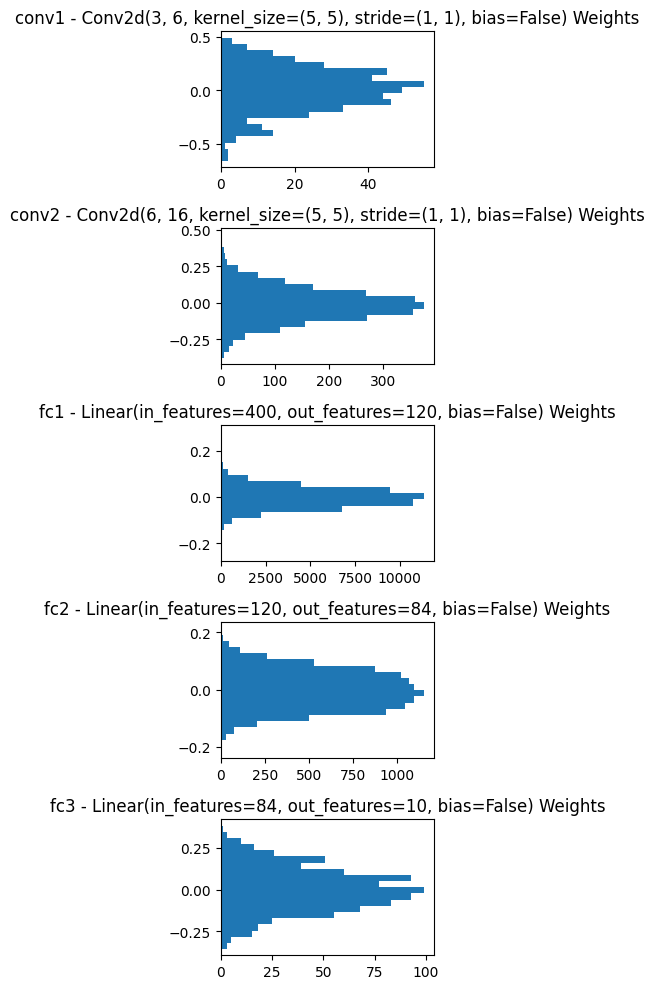

In [103]:
# ADD YOUR CODE HERE to plot distributions of weights

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)


# A convenience function which we use to copy CNNs
def plot_model_weights(model: nn.Module) -> nn.Module:
    layer_count = len([c for c in model.children() if isinstance(c, (nn.Conv2d, nn.Linear))])
    print(layer_count)

    fig, axes = plt.subplots(nrows=layer_count, figsize=(3,10))
    named_children = [(n, c) for n, c in model.named_children() if isinstance(c, (nn.Conv2d, nn.Linear))]
    for (name, layer), ax in zip(named_children, axes):
        print(name)
        if not isinstance(layer, (nn.Conv2d, nn.Linear)):
            continue
        weights = layer.weight.data.cpu().view(-1)
        ax.hist(
            weights,
            orientation='horizontal',
            bins=20
        )
        ax.set_title(f'{name} - {str(layer)} Weights')
    
    fig.set_tight_layout(True)


plot_model_weights(net)



# Question 2: Quantize Weights

In [104]:
net_q2 = copy_model(net)

In [105]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    scale =  127.0 / weights.abs().max() # using restricted range rather than full range in order to preserve relative values of weights (avoid clipping positive values that would map to 128)
    result = (weights * scale).round()
    return torch.clamp(result, min=-128, max=127), scale

In [106]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [107]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 49.87%


# Question 3: Visualize Activations

In [108]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    # NOTE: these activations are all profiled by the next layer's forward hook, which
    #  means they end up including any ops performed between the last layer's output and this layer's input 
    #  i.e. anything that was applied AFTER the previous layer was run.., including RELU, Pooling, etc..
    #   this is different from what https://arxiv.org/pdf/1712.05877.pdf suggests to do
    #   most notably, if we use the same clamping parameters for our activations (which are in the range [0...])
    #   and assume there is only a scaling factor (no zeroing variable), then we only utilize half of the 8-bit
    #   integer range for many layers
    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [109]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [110]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

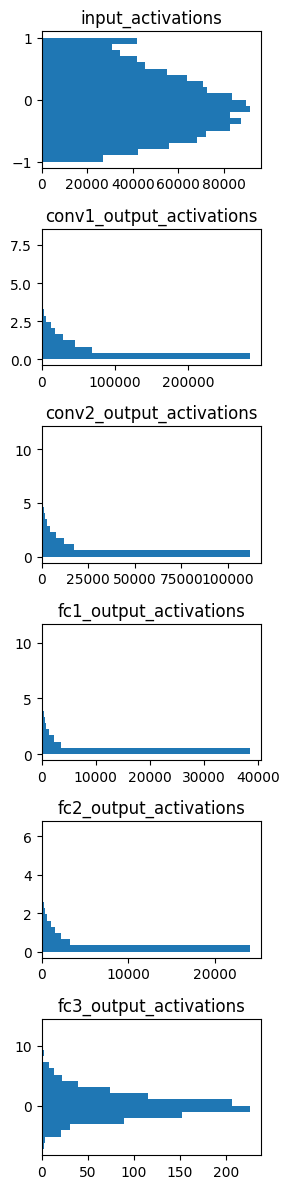

In [111]:
activations_all = [
    ('input_activations', input_activations),
    ('conv1_output_activations', conv1_output_activations),
    ('conv2_output_activations', conv2_output_activations),
    ('fc1_output_activations', fc1_output_activations),
    ('fc2_output_activations', fc2_output_activations),
    ('fc3_output_activations', fc3_output_activations),
]

fig, axes = plt.subplots(nrows=6, figsize=(3,12))
def add_activations_plt(title, activations, ax):
    ax.hist(
        activations,
        orientation='horizontal',
        bins=20
    )
    ax.set_title(title)

for (title, activations), ax in zip(activations_all, axes):
    add_activations_plt(title, activations, ax)

fig.set_tight_layout(True)


# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activations


In [112]:
def is_3sigma_normal(mean_a, std_a, min_a, max_a):
    lower = mean_a - (3*std_a)
    upper = mean_a + (3*std_a)
    return lower >= min_a and upper <= max_a
    
def print_3sigma_range(arr: np.ndarray):
    min_a, max_a = arr.min(), arr.max()
    mean_a, std_a = arr.mean(), arr.std()

    ranges = []
    dist_descriptor = None

    # normal enough
    ranges = [mean_a+i*std_a for i in range(-3, 4)]
    print(f'3-Sigma Ranges (mean and std based): ')
    sigma_bounds = ([lower, upper] for (lower,upper) in zip(reversed(ranges[0:3]), ranges[3:]))
    for i, bounds in enumerate(sigma_bounds):
        print(f'{i+1}-Sigma Range: {bounds}')
    
    # not normally distributed.. approximate 3-sigma with quantiles
    ranges = list(np.quantile(activations,[0.01, 0.05, 0.32, 0.68, 0.95, 0.99]))
    print(f'3-Sigma Ranges (quantile based): ')
    sigma_bounds = ([lower, upper] for (lower,upper) in zip(reversed(ranges[0:3]), ranges[3:]))
    for i, bounds in enumerate(sigma_bounds):
        print(f'{i+1}-Sigma Range: {bounds}')


for title, activations in activations_all:
    print(title)
    print(f'Range [{activations.min()}, {activations.max()}]')
    print_3sigma_range(activations)
    print()

input_activations
Range [-1.0, 1.0]
3-Sigma Ranges (mean and std based): 
1-Sigma Range: [-0.5524344645762663, -0.0567852506361131]
2-Sigma Range: [-1.0480836785164196, 0.4388639633040401]
3-Sigma Range: [-1.5437328924565727, 0.9345131772441934]
3-Sigma Ranges (quantile based): 
1-Sigma Range: [-0.34117645025253296, 0.17647063732147217]
2-Sigma Range: [-0.8117647171020508, 0.8352941274642944]
3-Sigma Range: [-0.9529411792755127, 0.9843137264251709]

conv1_output_activations
Range [0.0, 8.153975486755371]
3-Sigma Ranges (mean and std based): 
1-Sigma Range: [-0.23944059717336985, 0.5457859280676027]
2-Sigma Range: [-1.0246671224143424, 1.3310124533085754]
3-Sigma Range: [-1.809893647655315, 2.116238978549548]
3-Sigma Ranges (quantile based): 
1-Sigma Range: [0.0, 0.6141548061370853]
2-Sigma Range: [0.0, 2.1657462120056152]
3-Sigma Range: [0.0, 3.3879060316085763]

conv2_output_activations
Range [0.0, 11.547855377197266]
3-Sigma Ranges (mean and std based): 
1-Sigma Range: [-0.4485789359

# Question 4: Quantize Activations

In [113]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
         # again, using restricted range rather than full range in order to preserve relative values of weights (avoid clipping positive values that would map to 128)
        return 127.0 / np.abs(pixels).max()

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
        # our scales (q=s*r) are inverted relative to what is in the paper (r=q*s), which gives
        #  the scaling formula as:
        # q3 = S3/(S1*S2) * (q1*q2), where
        #  S1 - the scaling factor such that q1 = S1*r1
        #  S2 - the scaling factor such that q2 = S2*r2
        #  S3 - the scaling factor such that q3 = S3*r3
        # M = S3/(S1*S2)

        print_debug = False
        # ADD YOUR CODE HERE
        if print_debug:
            print('quantize_activations')
            print('n_w: ', n_w)
            print('n_initial_input: ', n_initial_input)
            print('ns: ', ns)
            print('activations: ', activations.min(), activations.max())

        s1 = n_w
        s3 = 127.0/np.abs(activations).max()

        # finally, we need to get the prior activation's scaler
        #  which can be calculated from the input scaler and the weights/output scaler
        #  from the prior layers
        # M_k = S3_k / (S1_k * S2_k-1) = S3_k / (S1_k * S2_input * prod( M_i*S1_i for i from 1 to k-1))
        #  and converted to our terms,
        # output_scale_k = activations_scale_k / (weights_scale_k * activations_scale_k-1)
        #    = activations_scale_k / (weights_scale_k * activations_scale_input * prod(weights_scale_i*output_scale_i for i from 1 to k-1)) 
        # so, S2_k-1 = activations_scale_input * prod(weights_scale_i*output_scale_i for i from 1 to k-1))
        
        s2 = n_initial_input * torch.prod(torch.tensor([w_scale*o_scale for w_scale,o_scale in ns]))

        output_scale = s3 / (s1*s2)
        if True: # make sure we will reproduce S3 as the next layer's S2 value.. this is trivial, but for a sanity check, do it
            tol = 1e-4
            sim_next_s2 = output_scale * s1 * s2
            if abs(sim_next_s2-s3) > tol:
                raise ValueError(f'expected sim_next_s2 ({sim_next_s2}) to be close to this layers s3 ({s3})')

        if print_debug:
            print(f'output_scale = activations_scale / (weights_scale * previous_activations_scale) = {s3} / ({s1} * {s2}) = {output_scale}')

        return output_scale

    @staticmethod
    def scale_round_and_clamp(x: torch.Tensor, scale, lower_bound, upper_bound) -> torch.Tensor:
        x = (x*scale).round()
        x = torch.clamp(x, min=lower_bound, max=upper_bound)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # NOTE: see NOTE in the function register_activation_profiling_hooks for 
        #  more detail about when to apply scales based on when the activations are being
        #  profiled

        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp
        lower_bound, upper_bound = -128, 127
        x = NetQuantized.scale_round_and_clamp(x, self.input_scale, lower_bound, upper_bound)

        # conv1
        x = self.pool(F.relu(self.conv1(x)))
        x = NetQuantized.scale_round_and_clamp(x, self.conv1.output_scale, lower_bound, upper_bound)
        
        # conv2
        x = self.pool(F.relu(self.conv2(x)))
        x = NetQuantized.scale_round_and_clamp(x, self.conv2.output_scale, lower_bound, upper_bound)
        
        # fc1
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = NetQuantized.scale_round_and_clamp(x, self.fc1.output_scale, lower_bound, upper_bound)

        # fc2
        x = F.relu(self.fc2(x))
        x = NetQuantized.scale_round_and_clamp(x, self.fc2.output_scale, lower_bound, upper_bound)

        # fc3
        x = self.fc3(x)
        x = NetQuantized.scale_round_and_clamp(x, self.fc3.output_scale, lower_bound, upper_bound)

        return x

In [114]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [115]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 50.02%


# Question 5: Quantize Biases

In [116]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [117]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.248
[1,  4000] loss: 1.960
[1,  6000] loss: 1.739
[1,  8000] loss: 1.627
[1, 10000] loss: 1.575
[1, 12000] loss: 1.499
[2,  2000] loss: 1.454
[2,  4000] loss: 1.382
[2,  6000] loss: 1.390
[2,  8000] loss: 1.355
[2, 10000] loss: 1.322
[2, 12000] loss: 1.331
Finished Training


In [118]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 54.35%


In [119]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [120]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 50.53%


In [121]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.fc3.bias.data < -2147483648).any() or (self.fc3.bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''
        # the scale for bias should match the scale used for the matrix multiplication of
        #  the weights and the input activations
        #  since our weights are inverses (see notes in function to calculate activation weights),
        #  
        # 
        #  to get the scaling from the matrix multiplication of the weights and the input activations,
        #    we can use our formula for the output scale M = S3/(S1*S2), where we know 1/(S1*S2)
        #    represents our scale for the matrix multiplication alone.
        #  so our scale to get from quantized numbers to real numbers would be 1/(S1*S2)
        #    and our scale to get from real numbers to quantized numbers will be S1*S2
        #  in our terms, weights_scale*previous_activations_scale
        #  so we need to calculate previous_activations_scale, as we did in the process of calculating output scales
        full_range = 2^32
        lower_bound, upper_bound = -full_range/2, (full_range/2) - 1
        print_debug = False
        previous_activations_scale = n_initial_input * torch.prod(torch.tensor([w_scale*o_scale for w_scale,o_scale in ns]))
        bias_scale = n_w * previous_activations_scale
        if print_debug:
            print('lower_bound and upper_bound for clamp: ', lower_bound, upper_bound)
            print('previous_activations_scale: ', previous_activations_scale)
            print('weights_scale: ', n_w)
            print('bias_scale: ', bias_scale)
        q_bias = NetQuantizedWithBias.scale_round_and_clamp(bias, bias_scale, lower_bound, upper_bound)
        
        return q_bias

In [122]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [123]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 50.72%
